**Goal:** Is to predict whether customers of a bank will churn or not which is a classification problem.

*A Churn is define as the Customer falling below the minimum balance Requirements*

**The Dataset is divided into 3 Categories**
- Demographic information about the Customer
1. Customer id
2. Vintage
3. Age
4. Gender
5. Dependents
6. Occupation
7. City

- Customer Bank Relationship
1. customer_nw_category
2. branch_code
3. days_since_last_transaction

- Transaction Information
1. current_balance
2. previous_month_end_balance
3. average_monthly_balance_prevQ
4. average_monthly_balance_prevQ2
5. current_month_credit
6. previous_month_credit
7. current_month_debit
8. previous_month_debit
9. current_month_balance
10. previous_month_balance

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12, 9)
sns.set(style = 'darkgrid')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Exploratory Data Analysis and Data Preparation

In [2]:
data_dir = r'/home/daniel/Desktop/programming/pythondatascience/datascience/datascienceprojects/datasets'
data = pd.read_csv(f"{data_dir}/{'churn_prediction.csv'}")
pd.set_option('display.max_columns', None)
print(data.shape)
data.head()

(28382, 21)


,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
0,1,3135,66,Male,0.0,self_employed,187.0,2,755,224.0,1458.71,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0
1,2,310,35,Male,0.0,self_employed,NaN,2,3214,60.0,5390.37,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0
2,4,2356,31,Male,0.0,salaried,146.0,2,41,NaN,3913.16,5815.29,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0
3,5,478,90,NaN,NaN,self_employed,1020.0,2,582,147.0,2291.91,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1
4,6,2531,42,Male,2.0,self_employed,1494.0,3,388,58.0,927.72,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1


In [3]:
data.churn.value_counts() / data.shape[0]

0    0.814671
1    0.185329
Name: churn, dtype: float64

The Not Churn rate of the customers is way higher than that of the customers that will churn. Therefore, we have to use either Under-Sampling or Over-Sampling methods on the churn feature.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28382 entries, 0 to 28381
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_id                     28382 non-null  int64  
 1   vintage                         28382 non-null  int64  
 2   age                             28382 non-null  int64  
 3   gender                          27857 non-null  object 
 4   dependents                      25919 non-null  float64
 5   occupation                      28302 non-null  object 
 6   city                            27579 non-null  float64
 7   customer_nw_category            28382 non-null  int64  
 8   branch_code                     28382 non-null  int64  
 9   days_since_last_transaction     25159 non-null  float64
 10  current_balance                 28382 non-null  float64
 11  previous_month_end_balance      28382 non-null  float64
 12  average_monthly_balance_prevQ   

### Check for Missing Values

In [5]:
data.isnull().sum().sort_values(ascending=False)

days_since_last_transaction       3223
dependents                        2463
city                               803
gender                             525
occupation                          80
customer_id                          0
average_monthly_balance_prevQ2       0
previous_month_balance               0
current_month_balance                0
previous_month_debit                 0
current_month_debit                  0
previous_month_credit                0
current_month_credit                 0
current_balance                      0
average_monthly_balance_prevQ        0
previous_month_end_balance           0
vintage                              0
branch_code                          0
customer_nw_category                 0
age                                  0
churn                                0
dtype: int64

In [6]:
(data.isnull().sum())/data.shape[0]

customer_id                       0.000000
vintage                           0.000000
age                               0.000000
gender                            0.018498
dependents                        0.086780
occupation                        0.002819
city                              0.028293
customer_nw_category              0.000000
branch_code                       0.000000
days_since_last_transaction       0.113558
current_balance                   0.000000
previous_month_end_balance        0.000000
average_monthly_balance_prevQ     0.000000
average_monthly_balance_prevQ2    0.000000
current_month_credit              0.000000
previous_month_credit             0.000000
current_month_debit               0.000000
previous_month_debit              0.000000
current_month_balance             0.000000
previous_month_balance            0.000000
churn                             0.000000
dtype: float64

### Missing Values Treatment

In [7]:
data.gender.value_counts()

Male      16548
Female    11309
Name: gender, dtype: int64

There is a good mix of Male and Female and arguably missing values cannot be filled with any of them. We could create a new category by assigning the value -1 to all the missing values in that column.

In [8]:
data.gender = data.gender.map({'Male': 0, 'Female': 1})
data.gender.fillna(value= -1, inplace= True)
data.gender.head()

0    0.0
1    0.0
2    0.0
3   -1.0
4    0.0
Name: gender, dtype: float64

In [9]:
print(data.occupation.unique())
print(data.occupation.value_counts())

['self_employed' 'salaried' 'retired' 'student' nan 'company']
self_employed    17476
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64


Remember to fill any missing categorical varables with the highest occuring category in that column, which in this case is self_employed.

In [10]:
data['occupation'].fillna(value=data.occupation.mode()[0], inplace=True)

In [11]:
data.city.value_counts().sort_values(ascending=False)

1020.0    3479
1096.0    2016
409.0     1334
146.0     1291
834.0     1138
          ... 
689.0        1
533.0        1
117.0        1
1453.0       1
723.0        1
Name: city, Length: 1604, dtype: int64

In [12]:
data['city'].fillna(value= data.city.mode()[0], inplace= True)

In [13]:
data['dependents'].fillna(value= data.dependents.mode()[0], inplace=True)

In [14]:
data['days_since_last_transaction'].fillna(value= data.days_since_last_transaction.mean(), inplace=True)

In [15]:
data.isnull().sum()

customer_id                       0
vintage                           0
age                               0
gender                            0
dependents                        0
occupation                        0
city                              0
customer_nw_category              0
branch_code                       0
days_since_last_transaction       0
current_balance                   0
previous_month_end_balance        0
average_monthly_balance_prevQ     0
average_monthly_balance_prevQ2    0
current_month_credit              0
previous_month_credit             0
current_month_debit               0
previous_month_debit              0
current_month_balance             0
previous_month_balance            0
churn                             0
dtype: int64

### Check for Outliers

In [16]:
data.describe()

,customer_id,vintage,age,gender,dependents,city,customer_nw_category,branch_code,days_since_last_transaction,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
count,28382.000000,28382.000000,28382.000000,28382.000000,28382.000000,28382.000000,28382.000000,28382.000000,28382.000000,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,2.838200e+04,28382.000000
mean,15143.508667,2364.336446,48.208336,0.379959,0.317102,802.444014,2.225530,925.975019,69.997814,7.380552e+03,7.495771e+03,7.496780e+03,7.124209e+03,3.433252e+03,3.261694e+03,3.658745e+03,3.339761e+03,7.451133e+03,7.495177e+03,0.185329
std,8746.454456,1610.124506,17.807163,0.522106,0.958386,428.316238,0.660443,937.799129,81.290871,4.259871e+04,4.252935e+04,4.172622e+04,4.457581e+04,7.707145e+04,2.968889e+04,5.198542e+04,2.430111e+04,4.203394e+04,4.243198e+04,0.388571
min,1.000000,180.000000,1.000000,-1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-5.503960e+03,-3.149570e+03,1.428690e+03,-1.650610e+04,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,-3.374180e+03,-5.171920e+03,0.000000
25%,7557.250000,1121.000000,36.000000,0.000000,0.000000,409.000000,2.000000,176.000000,13.000000,1.784470e+03,1.906000e+03,2.180945e+03,1.832507e+03,3.100000e-01,3.300000e-01,4.100000e-01,4.100000e-01,1.996765e+03,2.074407e+03,0.000000
50%,15150.500000,2018.000000,46.000000,0.000000,0.000000,879.000000,2.000000,572.000000,41.000000,3.281255e+03,3.379915e+03,3.542865e+03,3.359600e+03,6.100000e-01,6.300000e-01,9.193000e+01,1.099600e+02,3.447995e+03,3.465235e+03,0.000000
75%,22706.750000,3176.000000,60.000000,1.000000,0.000000,1096.000000,3.000000,1440.000000,83.000000,6.635820e+03,6.656535e+03,6.666887e+03,6.517960e+03,7.072725e+02,7.492350e+02,1.360435e+03,1.357553e+03,6.667958e+03,6.654693e+03,0.000000
max,30301.000000,12899.000000,90.000000,1.000000,52.000000,1649.000000,3.000000,4782.000000,365.000000,5.905904e+06,5.740439e+06,5.700290e+06,5.010170e+06,1.226985e+07,2.361808e+06,7.637857e+06,1.414168e+06,5.778185e+06,5.720144e+06,1.000000


## Outlier Detection and Treatment

### IQR (Inter Quantile Range) for Outlier Detection

In [17]:
def detect_outliers(dataframe, col):
    """
    Function to detect the presence of outliers in a column.
    """
    # 1st quantile 1%
    Q1 = dataframe[col].quantile(0.01)
    # 3rd quantile 99%
    Q3 = dataframe[col].quantile(0.99)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    
    print(f"Q1 is {Q1} while Q3 is {Q3}")
    print(f"IQR is {IQR}")
    print(f"The Lower limit is {lower_limit} while the Upper limit is {upper_limit}")
    # Check if the Probability Distribution Function(PDF) is a Gaussian Distribution
    sns.distplot(dataframe[col])
    # Return the detected Outliers
    return data.loc[(dataframe[col] < lower_limit) | (dataframe[col] > upper_limit)]

In [18]:
def treat_right_skewed(dataframe, col):
    """
    Function to treat the right skew present in a column.
    
    Args:
        dataframe (DataFrame) : dataframe of the data
        col (string) : column name
        
    Returns:
        float : with no outliers
    """
    q = dataframe[col].quantile(0.99)
    return dataframe.loc[dataframe[col] < q]

def treat_left_skewed(dataframe, col):
    """
    Function to treat the left skew present in a column.
    
    Args:
        dataframe (DataFrame) : dataframe of the data
        col (string) : column name
        
    Returns:
        float : with no outliers
    """
    q = dataframe[col].quantile(0.01)
    return dataframe.loc[dataframe[col] > q]

In [19]:
data.skew()

customer_id                         0.000505
vintage                             0.879449
age                                 0.330589
gender                              0.101124
dependents                         15.733793
city                               -0.117118
customer_nw_category               -0.281379
branch_code                         1.245675
days_since_last_transaction         1.746044
current_balance                    99.030683
previous_month_end_balance         92.948220
average_monthly_balance_prevQ      96.648620
average_monthly_balance_prevQ2     88.893453
current_month_credit              143.315551
previous_month_credit              42.560005
current_month_debit               115.620280
previous_month_debit               30.641984
current_month_balance              97.313457
previous_month_balance             93.398645
churn                               1.619748
dtype: float64

It can be seen that these columns "current_balance, previous_month_end_balance, average_monthly_balance_prevQ, average_monthly_balance_prevQ2, current_month_credit, previous_month_credit, current_month_debit, previous_month_debit, current_month_balance, previous_month_balance" are highly skewed.

Q1 is 47.6892 while Q3 is 64781.362599999804
IQR is 64733.6733999998
The Lower limit is -97052.82089999972 while the Upper limit is 161881.8726999995


,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
245,267,2809,81,0.0,0.0,retired,1020.0,1,16,9.000000,244686.74,214757.79,99212.05,31312.68,37857.84,214286.41,7928.90,509.86,224531.30,69803.24,0
701,749,1153,90,0.0,0.0,self_employed,1020.0,2,2255,35.000000,307672.70,308291.63,307417.18,310121.23,0.61,172.39,0.61,179.51,308078.13,306390.07,0
764,816,2255,54,1.0,0.0,self_employed,1096.0,1,328,13.000000,169603.37,178183.61,164759.49,61923.34,299.04,19176.54,9159.61,0.47,169196.97,171736.97,0
1471,1576,3015,46,0.0,0.0,salaried,1020.0,2,239,20.000000,192364.72,4132.72,47455.08,32.89,193846.99,4458.28,4832.03,285.22,141176.07,702.42,1
1704,1830,749,90,-1.0,0.0,self_employed,382.0,2,785,4.000000,216426.11,130711.83,151073.08,138497.41,85714.74,0.46,0.46,0.46,191795.57,130711.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27153,28994,1700,70,1.0,0.0,self_employed,15.0,2,888,80.000000,265872.34,266218.71,269238.17,356090.29,0.53,0.53,0.53,0.53,265979.83,267324.70,0
27779,29652,3875,66,0.0,0.0,self_employed,1020.0,1,145,44.000000,262544.43,287655.14,287730.61,137980.84,0.39,16716.51,3578.24,22500.86,282547.36,297989.62,0
27856,29735,194,90,0.0,0.0,self_employed,904.0,1,296,213.000000,1435872.80,1435872.80,1435872.80,413107.52,0.24,0.24,0.24,0.24,1435872.80,1435872.80,0
28030,29924,412,90,-1.0,0.0,self_employed,623.0,2,218,69.997814,177074.17,177074.17,177074.17,174972.39,0.04,0.04,0.04,0.04,177074.17,177074.17,0


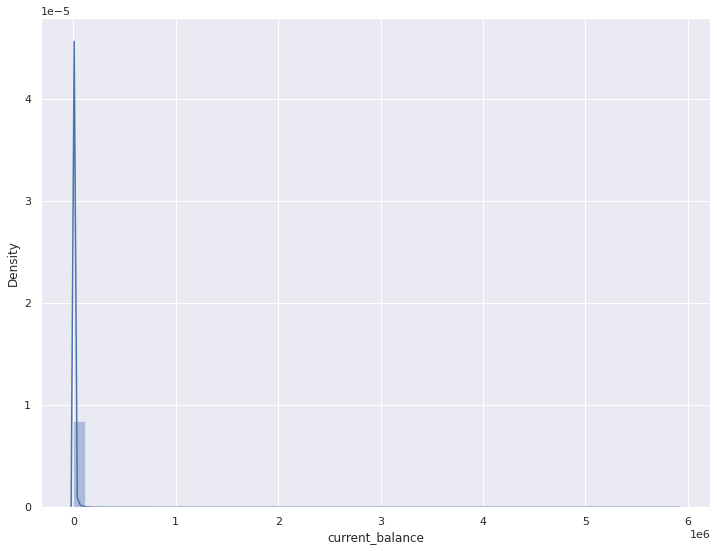

In [20]:
detect_outliers(data, 'current_balance')

Q1 is 74.1782 while Q3 is 66212.91159999967
IQR is 66138.73339999968
The Lower limit is -99133.92189999952 while the Upper limit is 165421.0116999992


,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
245,267,2809,81,0.0,0.0,retired,1020.0,1,16,9.000000,244686.74,214757.79,99212.05,31312.68,37857.84,214286.41,7928.90,509.86,224531.30,69803.24,0
701,749,1153,90,0.0,0.0,self_employed,1020.0,2,2255,35.000000,307672.70,308291.63,307417.18,310121.23,0.61,172.39,0.61,179.51,308078.13,306390.07,0
764,816,2255,54,1.0,0.0,self_employed,1096.0,1,328,13.000000,169603.37,178183.61,164759.49,61923.34,299.04,19176.54,9159.61,0.47,169196.97,171736.97,0
2428,2596,1379,76,1.0,0.0,self_employed,409.0,1,336,27.000000,285560.79,283180.88,287430.99,98006.64,1786.23,1725.27,26.99,7261.23,285443.95,289522.70,1
3711,3957,285,54,0.0,2.0,salaried,905.0,2,1421,13.000000,31833.45,332504.88,319030.57,11525.29,17143.47,287032.23,317814.90,296429.19,315194.04,363272.49,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27153,28994,1700,70,1.0,0.0,self_employed,15.0,2,888,80.000000,265872.34,266218.71,269238.17,356090.29,0.53,0.53,0.53,0.53,265979.83,267324.70,0
27779,29652,3875,66,0.0,0.0,self_employed,1020.0,1,145,44.000000,262544.43,287655.14,287730.61,137980.84,0.39,16716.51,3578.24,22500.86,282547.36,297989.62,0
27856,29735,194,90,0.0,0.0,self_employed,904.0,1,296,213.000000,1435872.80,1435872.80,1435872.80,413107.52,0.24,0.24,0.24,0.24,1435872.80,1435872.80,0
28030,29924,412,90,-1.0,0.0,self_employed,623.0,2,218,69.997814,177074.17,177074.17,177074.17,174972.39,0.04,0.04,0.04,0.04,177074.17,177074.17,0


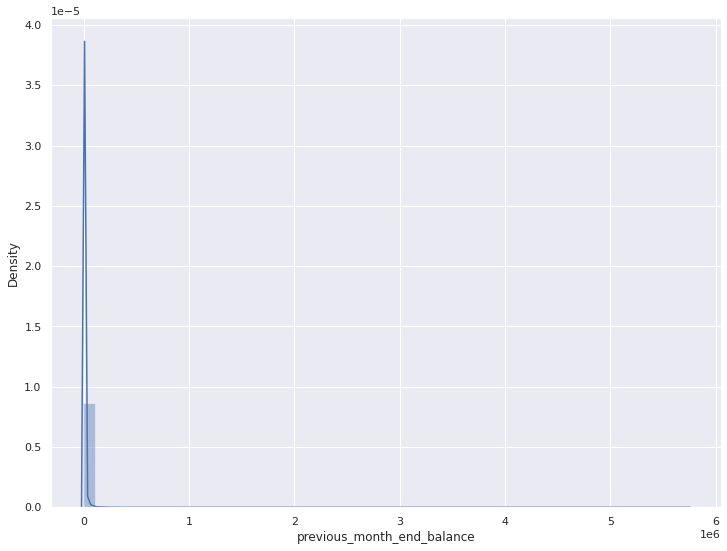

In [21]:
detect_outliers(data, 'previous_month_end_balance')

## Dealing with Outliers using Log Transformation

In [22]:
num_cols = []
for col in data.columns:
    if (data[col].dtypes != 'object'):
        if col not in [
            'customer_id', 'vintage', 'age', 'dependents',
            'gender', 'city', 'branch_code', 'customer_nw_category',
            'days_since_last_transaction', 'churn'
        ]:
            num_cols.append(col)
num_features = data[num_cols]
num_features.head()

,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance
0,1458.71,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71
1,5390.37,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61
2,3913.16,5815.29,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14
3,2291.91,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79
4,927.72,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16


In [23]:
for i in num_features:
    data[i] = np.log(data[i] + 17000)
    
print(data.skew())

customer_id                        0.000505
vintage                            0.879449
age                                0.330589
gender                             0.101124
dependents                        15.733793
city                              -0.117118
customer_nw_category              -0.281379
branch_code                        1.245675
days_since_last_transaction        1.746044
current_balance                    3.832863
previous_month_end_balance         3.939151
average_monthly_balance_prevQ      4.126018
average_monthly_balance_prevQ2     3.796120
current_month_credit               6.558917
previous_month_credit              6.181481
current_month_debit                5.976870
previous_month_debit               5.732077
current_month_balance              3.974428
previous_month_balance             4.046259
churn                              1.619748
dtype: float64


# Feature Analysis

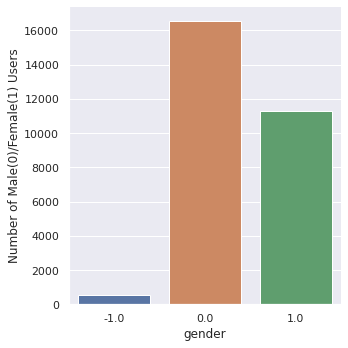

In [24]:
c = sns.factorplot(x='gender', data=data, kind='count')
c.set_ylabels('Number of Male(0)/Female(1) Users');

This shows there are more Male(0) users than Female(1) users in the bank.

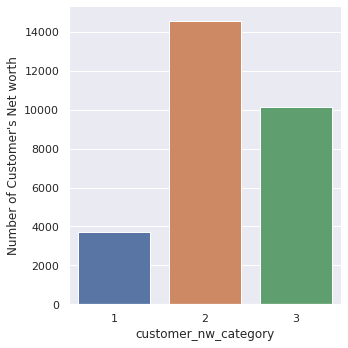

In [25]:
c = sns.factorplot(x='customer_nw_category', data=data, kind='count')
c.set_ylabels("Number of Customer's Net worth");

This shows that customers with Medium(2) Net worth are more than those in the high(3) class.

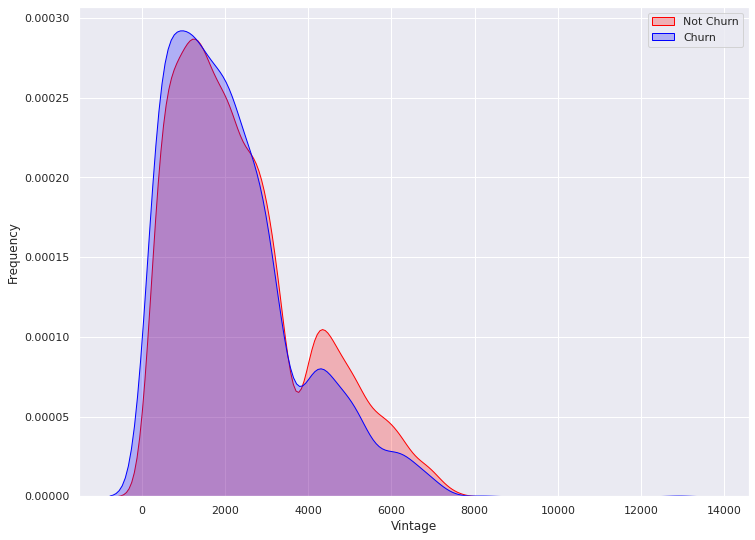

In [26]:
# Explore Vintage vs Churn
c = sns.kdeplot(data['vintage'][(data['churn'] == 0) & (data['vintage'])], color='Red', shade=True)
c = sns.kdeplot(data['vintage'][(data['churn'] == 1) & (data['vintage'])], color='Blue', shade=True)
c.set_xlabel('Vintage')
c.set_ylabel('Frequency')
c.legend(['Not Churn', 'Churn']);

When we superimpose the two densities, for most frequent values the churning customers are slightly higher, while the Vintage values ranging from 4000-8000 are mostly non churning customers.

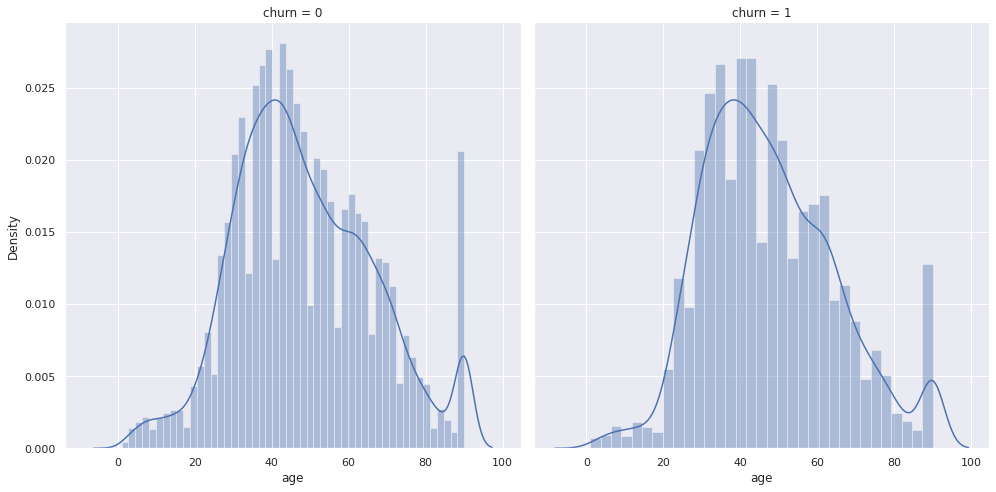

In [27]:
# Explore Age vs Churn
c = sns.FacetGrid(col='churn', data=data, size=7)
c = c.map(sns.distplot, 'age')

Age PDF seems to be a close gaussian distribution.

We notice there is a peak corresponding to young customers(20-60) that will Not Churn. We also see that customers between 80-100 have higher chances to Churn.

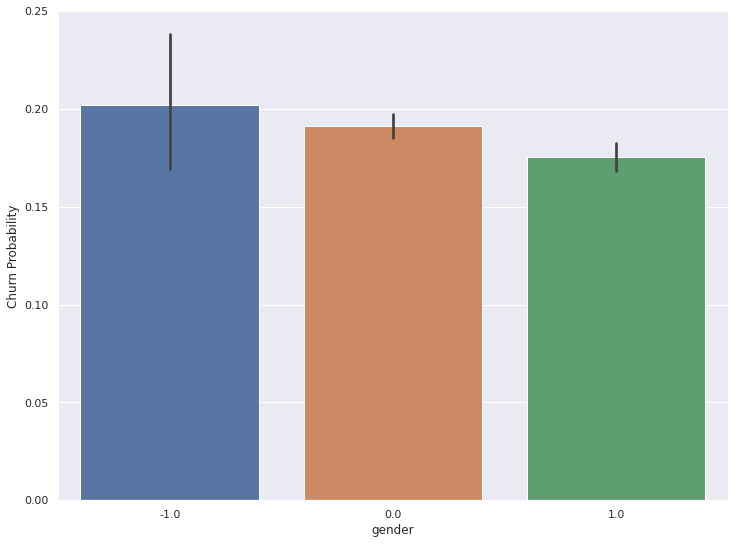

In [28]:
# Explore Gender vs Churn
c = sns.barplot(x= 'gender', y= 'churn', data= data)
c = c.set_ylabel('Churn Probability')

It is clearly obvious that Female(1) customers have lesser chance of churning compared to Male(0) Users.

In [29]:
data[['gender', 'churn']].groupby('gender').mean()

,churn
gender,
-1.0,0.201905
0.0,0.191504
1.0,0.175524


Gender feature is not that important which can be seen from the analysis above.

In [30]:
# Explore Dependents vs Churn
data[['dependents', 'churn']].groupby('churn').mean()

,dependents
churn,
0,0.303693
1,0.376046


The dependents feature is not important.

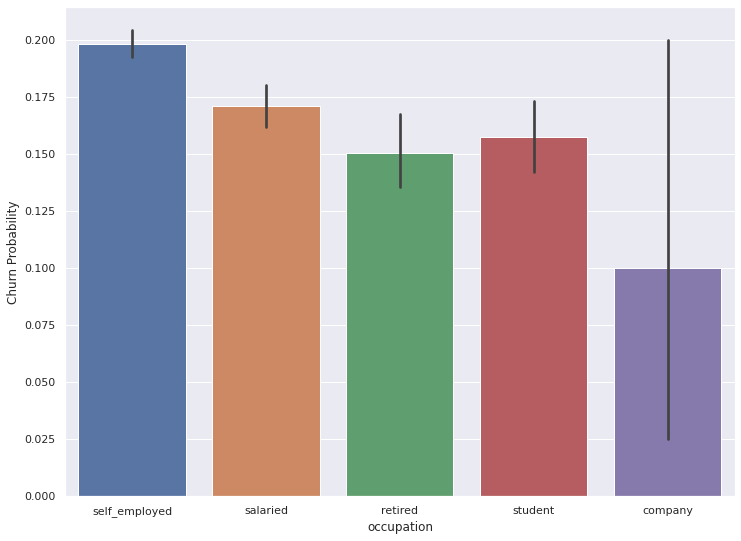

In [31]:
# Explore Occupation vs Churn
c = sns.barplot(x= 'occupation', y= 'churn', data= data)
c = c.set_ylabel('Churn Probability')

It makes more sense that the Company and Retired Occupations has less chances of churning than the rest which has higher probability to Churn.

We can see a significant difference in the different occupations and certainly would be interesting to use as a feature for prediction of Churn.

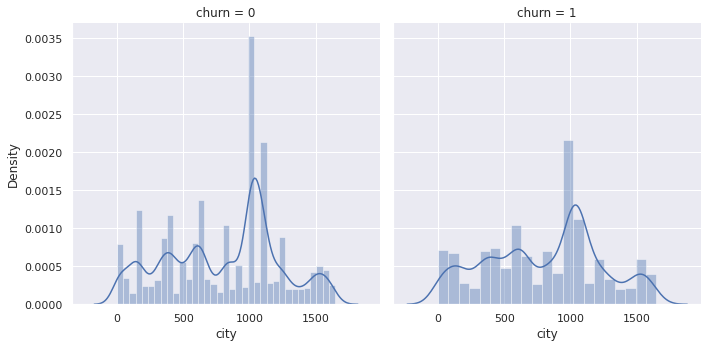

In [32]:
# Explore City vs Churn
c = sns.FacetGrid(col='churn', data= data, size= 5)
c = c.map(sns.distplot, 'city')

These cities are anonymised, so we cannot draw any conclusion from here. Therefore, it is not an important feature.

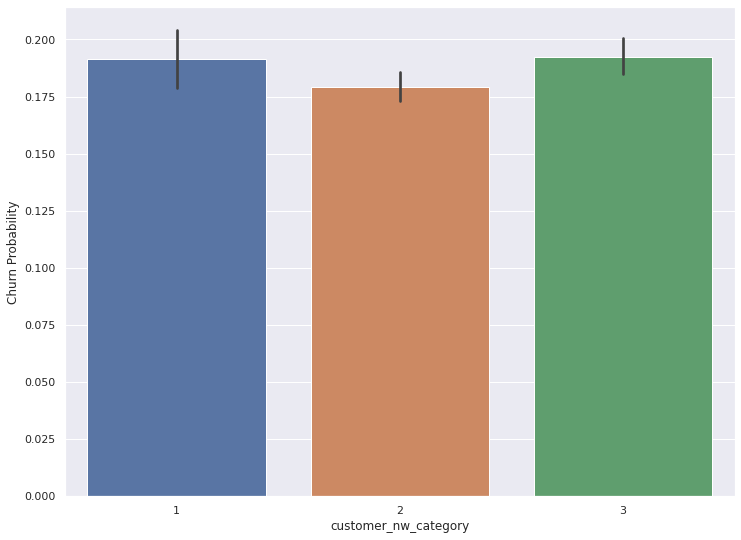

In [33]:
# Explore Customer Networth category vs Churn
c = sns.barplot(x= 'customer_nw_category', y= 'churn', data= data)
c = c.set_ylabel('Churn Probability')

From the visualization above, it can be seen that customers with medium(2) networth has lesser chance of churning but the rest has higher probability to churn.

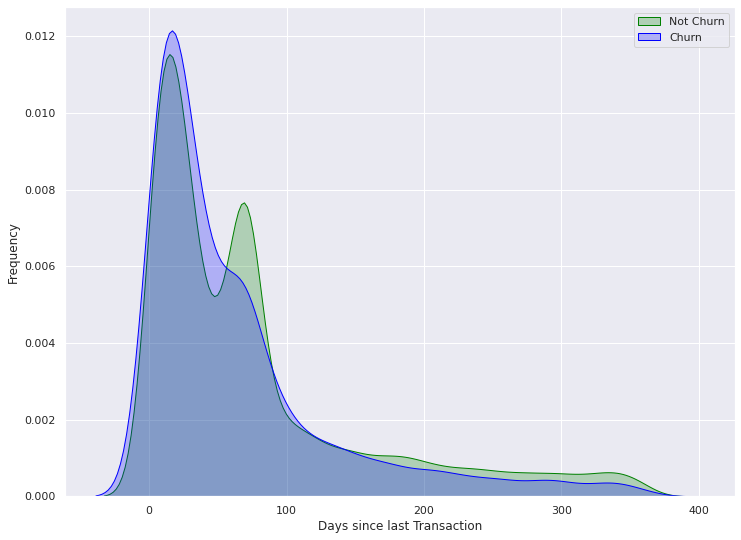

In [34]:
# Explore Days since last transaction vs Churn
c = sns.kdeplot(data['days_since_last_transaction'][(data['churn'] == 0) & (data['days_since_last_transaction'])],
                color='green', shade= True)
c = sns.kdeplot(data['days_since_last_transaction'][(data['churn'] == 1) & (data['days_since_last_transaction'])],
               color='blue', shade= True)
c.set_xlabel('Days since last Transaction')
c.set_ylabel('Frequency')
c.legend(['Not Churn', 'Churn']);

1 year is 365 days. the transaction that occured after 1 year can be seen that customers with their last transactions between 60-400 days will Not Churn.

In [35]:
# Let's reduce the skewness of the Current Balance
data = treat_right_skewed(data, 'current_balance')

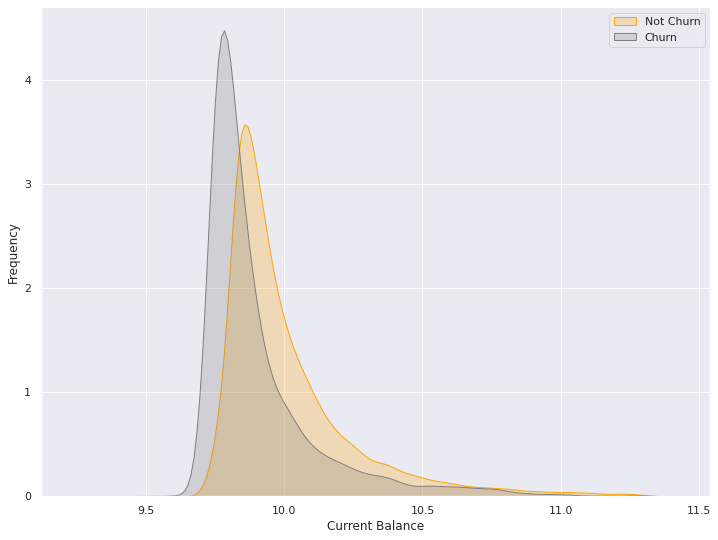

In [36]:
# Explore Current balance vs Churn
c = sns.kdeplot(data['current_balance'][(data['churn']==0) & (data['current_balance'])],
                shade= True, color='orange')
c = sns.kdeplot(data['current_balance'][(data['churn']==1) & (data['current_balance'])],
                shade= True, color='gray')
c.set_xlabel('Current Balance')
c.set_ylabel('Frequency')
c.legend(['Not Churn', 'Churn']);

Customers with the most money as of today are non churning customers.

In [37]:
data = treat_right_skewed(data, 'previous_month_end_balance')

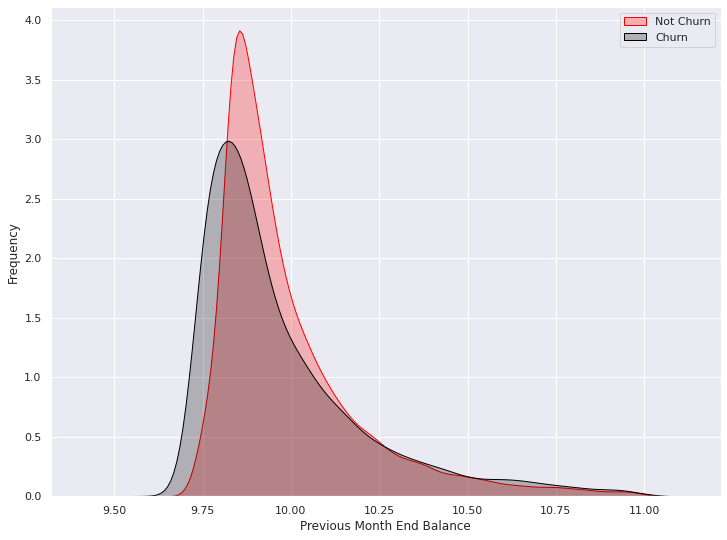

In [38]:
# Explore Previous month end balance vs Churn
c = sns.kdeplot(data['previous_month_end_balance'][(data['churn']==0) & (data['previous_month_end_balance'])],
                shade= True, color='red')
c = sns.kdeplot(data['previous_month_end_balance'][(data['churn']==1) & (data['previous_month_end_balance'])],
                shade= True, color='black')
c.set_xlabel('Previous Month End Balance')
c.set_ylabel('Frequency')
c.legend(['Not Churn', 'Churn']);

Persons with the most previous month end balance are not likely to Churn.

In [39]:
data = treat_right_skewed(data, 'average_monthly_balance_prevQ')

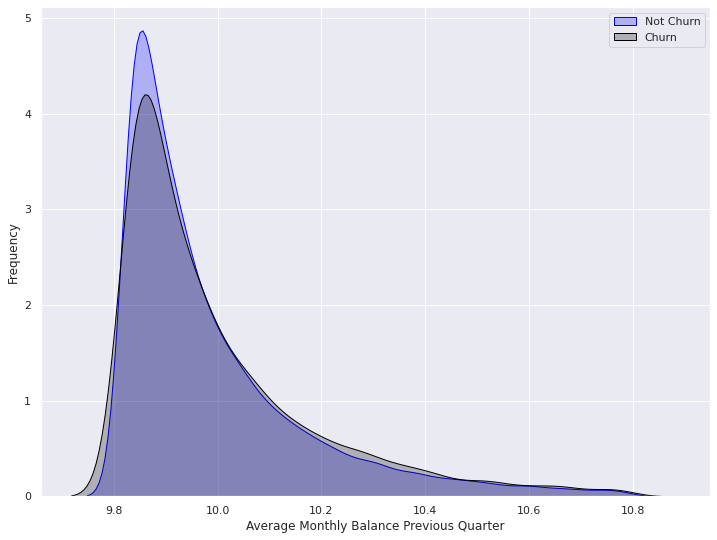

In [40]:
# Explore Average monthly balance previous Quarter vs Churn
c = sns.kdeplot(data['average_monthly_balance_prevQ'][(data['churn']==0) & (data['average_monthly_balance_prevQ'])],
               color='blue', shade= True)
c = sns.kdeplot(data['average_monthly_balance_prevQ'][(data['churn']==1) & (data['average_monthly_balance_prevQ'])],
               color='black', shade= True)
c.set_xlabel('Average Monthly Balance Previous Quarter')
c.set_ylabel('Frequency')
c.legend(['Not Churn', 'Churn']);

Most customers with the Average Monthly Balance in the previous Quarter are not likely to Churn.

In [41]:
data = treat_left_skewed(data, 'average_monthly_balance_prevQ2')

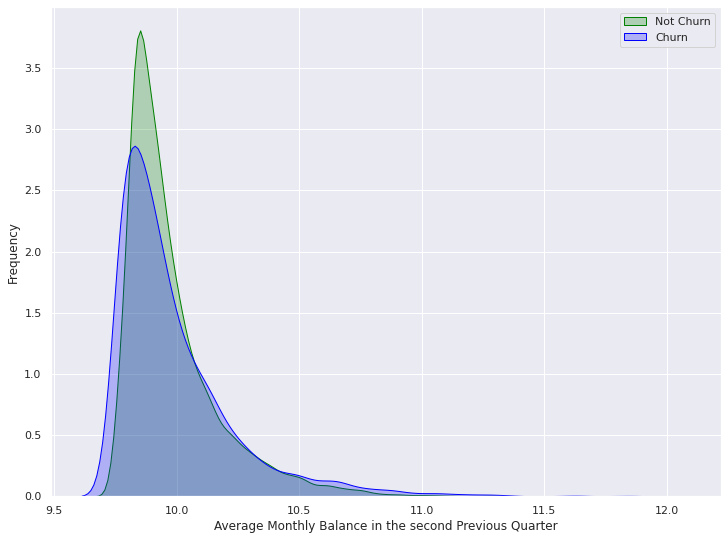

In [42]:
# Explore Average monthly balance previous second Quarter vs Churn
c = sns.kdeplot(data['average_monthly_balance_prevQ2'][(data['churn']==0) & (data['average_monthly_balance_prevQ2'])],
               color='green', shade= True)
c = sns.kdeplot(data['average_monthly_balance_prevQ2'][(data['churn']==1) & (data['average_monthly_balance_prevQ2'])],
               color='blue', shade= True)
c.set_xlabel('Average Monthly Balance in the second Previous Quarter')
c.set_ylabel('Frequency')
c.legend(['Not Churn', 'Churn']);

Most customers with the Average Monthly Balance in the second previous Quarter are not likely to Churn.

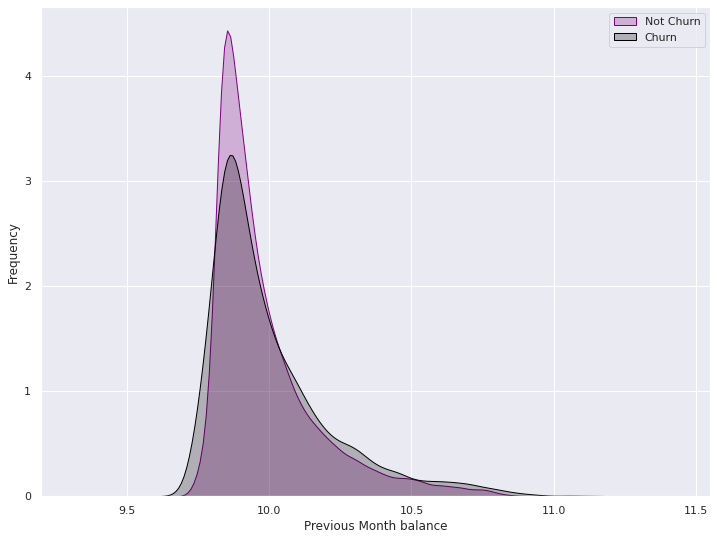

In [43]:
# Explore Previous month balance vs Churn
c = sns.kdeplot(data['previous_month_balance'][(data['churn']==0) & (data['previous_month_balance'])],
               color='purple', shade= True)
c = sns.kdeplot(data['previous_month_balance'][(data['churn']==1) & (data['previous_month_balance'])],
               color='black', shade= True)
c.set_xlabel('Previous Month balance')
c.set_ylabel('Frequency')
c.legend(['Not Churn', 'Churn']);

Majority of the customers with balance in the previous month are not likely to churn.

In [44]:
data = treat_right_skewed(data, 'current_month_credit')

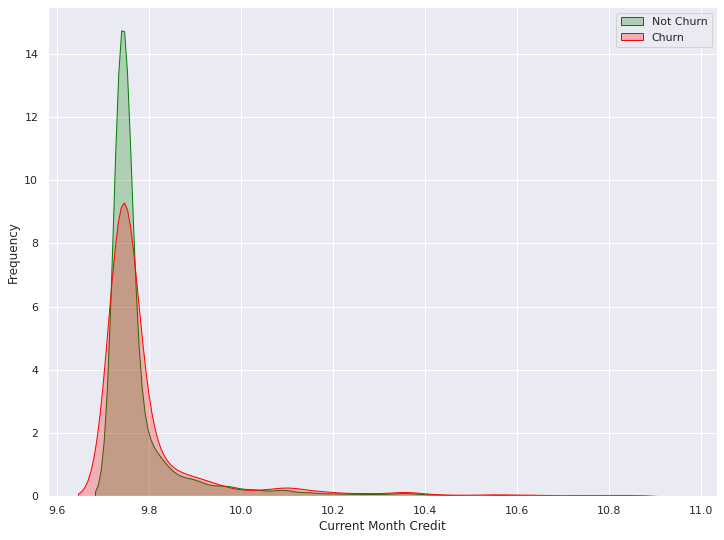

In [45]:
# Explore Current Month Credit vs Churn
c = sns.kdeplot(data['current_month_credit'][(data['churn']==0) & (data['current_month_credit'])],
               color='green', shade= True)
c = sns.kdeplot(data['current_month_credit'][(data['churn']==1) & (data['current_month_credit'])],
               color='red', shade= True)
c.set_xlabel('Current Month Credit')
c.set_ylabel('Frequency')
c.legend(['Not Churn', 'Churn']);

Most customers with credit in the present month are not likely to Churn.

In [46]:
data = treat_right_skewed(data, 'previous_month_credit')

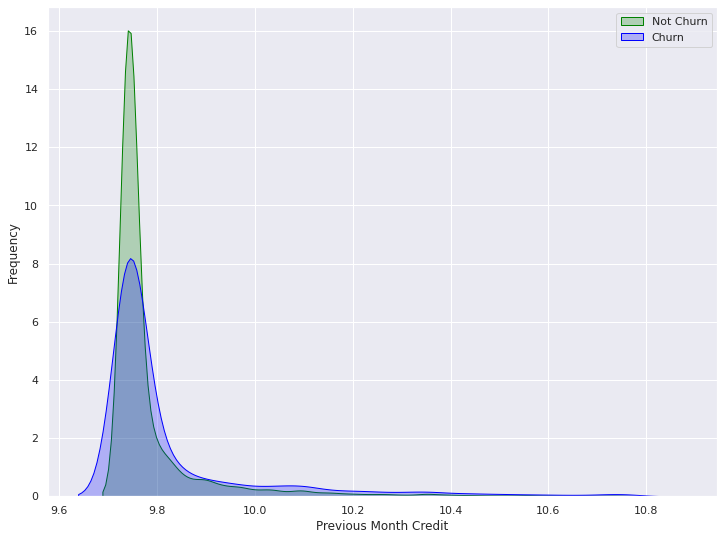

In [47]:
# Explore Previous Month Credit vs Churn
c = sns.kdeplot(data['previous_month_credit'][(data['churn']==0) & (data['previous_month_credit'])],
               color='green', shade= True)
c = sns.kdeplot(data['previous_month_credit'][(data['churn']==1) & (data['previous_month_credit'])],
               color='blue', shade= True)
c.set_xlabel('Previous Month Credit')
c.set_ylabel('Frequency')
c.legend(['Not Churn', 'Churn']);

Likewise, most customers with credit in the previous month are not likely to Churn.

## EDA Conclusions for Balance & Credit
- For all balance and credit features the lower values have much higher proportion of churning customers.

In [48]:
data = treat_right_skewed(data, 'current_month_debit')

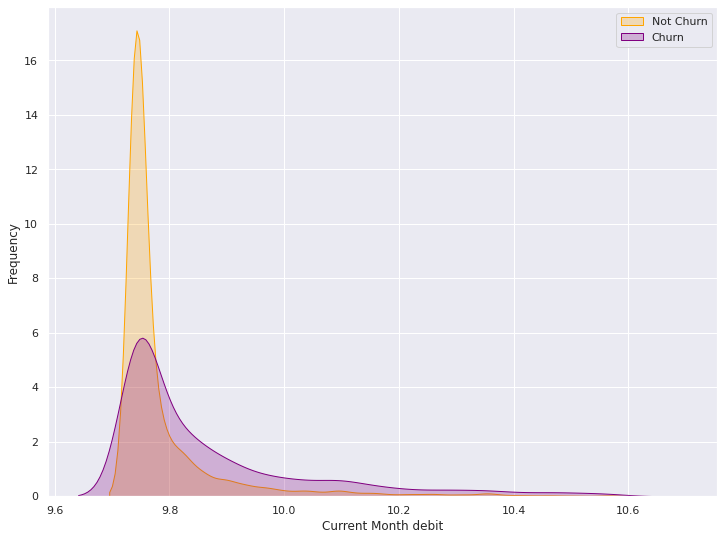

In [49]:
# Explore Current Month debit vs Churn
c = sns.kdeplot(data['current_month_debit'][(data['churn']==0) & (data['current_month_debit'])],
               color='orange', shade= True)
c = sns.kdeplot(data['current_month_debit'][(data['churn']==1) & (data['current_month_debit'])],
               color='purple', shade= True)
c.set_xlabel('Current Month debit')
c.set_ylabel('Frequency')
c.legend(['Not Churn', 'Churn']);

Most customers with debit in the current month are not likely to Churn.

In [50]:
data = treat_right_skewed(data, 'previous_month_debit')

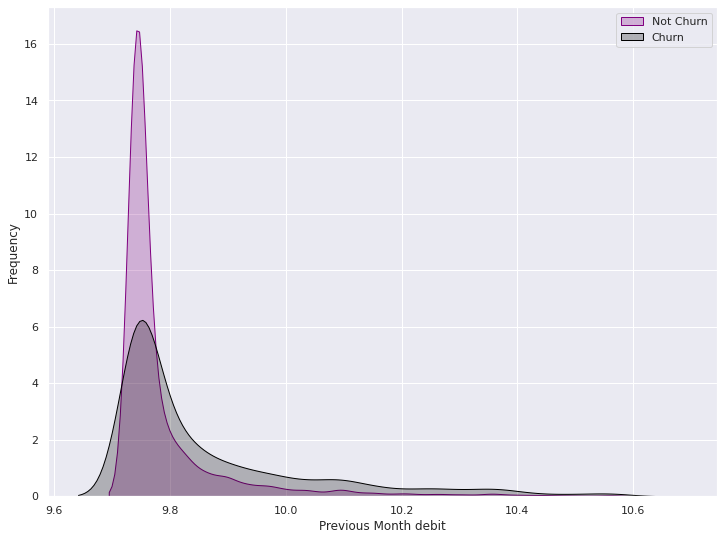

In [51]:
# Explore Previous Month debit vs Churn
c = sns.kdeplot(data['previous_month_debit'][(data['churn']==0) & (data['previous_month_debit'])],
               color='purple', shade= True)
c = sns.kdeplot(data['previous_month_debit'][(data['churn']==1) & (data['previous_month_debit'])],
               color='black', shade= True)
c.set_xlabel('Previous Month debit')
c.set_ylabel('Frequency')
c.legend(['Not Churn', 'Churn']);

Most customers with debit in the previous month are not likely to Churn.

## EDA Conclusions for Debit
* For debit values, we see that there is a significant difference in the distribution for churn and non churn and it might turn out to be an important feature.

# Feature Engineering

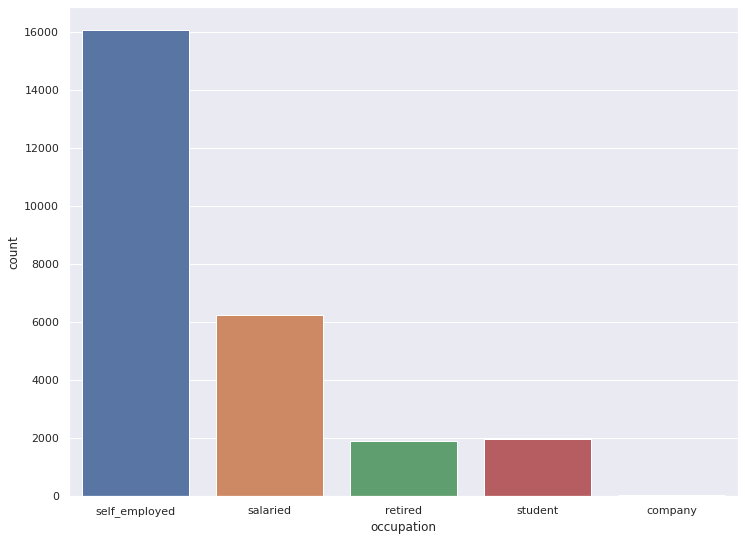

In [52]:
c = sns.countplot(x='occupation', data= data)

In [53]:
data_cleaned = pd.get_dummies(data= data, columns = ['occupation'])
data_cleaned.drop(['customer_id', 'city', 'branch_code'], axis= 1, inplace= True)
data_cleaned.head()

,vintage,age,gender,dependents,customer_nw_category,days_since_last_transaction,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,occupation_company,occupation_retired,occupation_salaried,occupation_self_employed,occupation_student
0,3135,66,0.0,0.0,2,224.000000,9.823292,9.823292,9.823292,9.822769,9.740980,9.740980,9.740980,9.740980,9.823292,9.823292,0,0,0,0,1,0
1,310,35,0.0,0.0,2,60.000000,10.016386,10.154428,10.118569,10.289410,9.741002,9.741002,10.020660,9.746866,10.064619,10.157649,0,0,0,0,1,0
2,2356,31,0.0,0.0,2,69.997814,9.948134,10.035186,9.994706,9.894242,9.741005,9.741005,10.045279,9.756102,9.999083,10.001981,0,0,0,1,0,0
3,478,90,-1.0,0.0,2,147.000000,9.867441,9.867441,9.856634,9.798490,9.740996,9.740996,9.740996,9.859710,9.867441,9.834662,1,0,0,0,1,0
4,2531,42,0.0,2.0,3,58.000000,9.794103,9.820199,9.833243,9.845388,9.740988,9.782145,9.775007,9.827581,9.806820,9.835057,1,0,0,0,1,0


# Feature Selections
#### Now, we will select our important features based on the EDA conclusions.

In [54]:
# Vintage, Age, Occupation, Current Balance, Previous month end balance, Average monthly balance previous second Quarter, 
# Previous month balance, Current Month Credit, Previous Month Credit, Current Month debit, Previous Month debit
baseline_feats = [
    'occupation_company', 'occupation_retired', 'occupation_salaried',
    'occupation_self_employed', 'occupation_student', 'vintage',
    'age', 'current_balance', 'previous_month_end_balance',
    'average_monthly_balance_prevQ', 'previous_month_balance', 'current_month_credit',
    'previous_month_credit', 'current_month_debit', 'previous_month_debit'
]

In [55]:
x = df_baseline = data_cleaned[baseline_feats]
y = data_cleaned.churn
data_cleaned = data_cleaned.drop(['churn'], axis= 1)

# Imbalanced Class treatment

In [56]:
smote = SMOTE(sampling_strategy = 'minority')
x_sm, y_sm = smote.fit_resample(x, y)

print(y_sm.value_counts(normalize = True) * 100)
print(y_sm.value_counts())

0    50.0
1    50.0
Name: churn, dtype: float64
0    21739
1    21739
Name: churn, dtype: int64


# Split and Scale the Data

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(x_sm, y_sm, random_state= 42, test_size= 0.33)

In [58]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(29130, 15) (14348, 15) (29130,) (14348,)


In [59]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled= pd.DataFrame(X_train_scaled, columns= x.columns)
X_train_scaled.head()

,occupation_company,occupation_retired,occupation_salaried,occupation_self_employed,occupation_student,vintage,age,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,previous_month_balance,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit
0,-0.028715,-0.227795,2.232482,-1.096576,-0.239399,0.474044,-0.836825,-0.462585,-0.553761,-0.979081,-0.818310,-0.425098,-0.088798,-0.430643,-0.112812
1,-0.028715,4.389920,-0.447932,-1.096576,-0.239399,-0.571098,1.165533,-0.861405,-0.514246,-0.774032,-0.674271,0.429233,0.157876,0.760690,-0.288906
2,-0.028715,-0.227795,2.232482,-1.096576,-0.239399,1.916392,-0.012324,0.061699,-0.017621,-0.049828,-0.048643,-0.425150,-0.215225,-0.515704,-0.243779
3,-0.028715,-0.227795,-0.447932,0.911929,-0.239399,1.290202,-0.483468,-0.298086,-0.698481,-0.829838,-0.794133,0.069661,-0.473904,-0.525147,-0.620947
4,-0.028715,-0.227795,-0.447932,0.911929,-0.239399,0.779783,-0.189003,1.772461,-0.270274,-0.213709,-0.337670,1.042256,-0.474056,-0.625070,-0.621087


# Model Building and Evaluation Metrics
Since this is a Binary Classification problem, we can use the 2 following popular metrics.
1. Recall
2. Area under the Receiver Operating Characteristic Curve

Now, we are looking at the recall value here because a customer falsely marked as churn will be as bad as a customer who was not detected as a churning customer and appropriate measures were not taken by the bank to stop him/her from churning.

The ROC AUC is the area under the curve when plotting the (normalized) true positive rate (y-axis) and the false positive rate (x-axis).

Our main metric here would be Recall values, while AUC ROC Score would take care of how well predicted probabilites are able to differentiate between the 2 classes.

In [60]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, Y_train)
pred_log = log_reg.predict_proba(X_test_scaled)[:, 1]
y_pred = log_reg.predict(X_test_scaled)

print(pred_log)
print(f"roc auc score of Log Reg: {roc_auc_score(Y_test, pred_log)}")

[0.96258839 0.82628185 0.51214296 ... 0.99923221 0.19861033 0.71612265]
roc auc score of Log Reg: 0.8801362096254906


ROC AUC score of Logistic Regression: 0.8801
Recall score of Logistic Regression: 0.7378


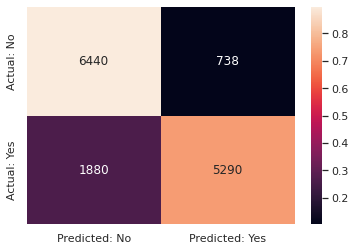

In [61]:
cm_log = confusion_matrix(Y_test, y_pred)

def confusion_matrix_plot(cm, normalized= True, cmap= 'bone'):
    norm_cm = cm
    if normalized:
        plt.figure(figsize=(6,4))
        norm_cm = (cm.astype('float')/ cm.sum(axis= 1)[:, np.newaxis])
        return sns.heatmap(norm_cm, annot= cm, fmt='g', 
                           xticklabels= ['Predicted: No', 'Predicted: Yes'], yticklabels=['Actual: No', 'Actual: Yes'])

print(f"ROC AUC score of Logistic Regression: {roc_auc_score(Y_test, pred_log):.4f}")
print(f"Recall score of Logistic Regression: {recall_score(Y_test, y_pred):.4f}")
confusion_matrix_plot(cm_log)
plt.show()

In the confusion matrix, out of 7178 samples of non churning customers the model predicted 6440 correctly and 738 wrong predictions while for the churning customers the model predicted 5290 correctly and 1880 wrongly for 7170 samples.

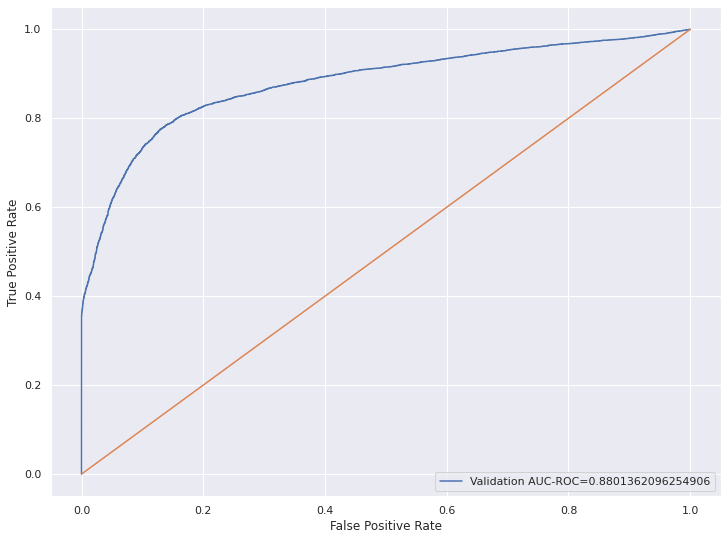

In [62]:
fpr, tpr, _ = roc_curve(Y_test, pred_log)
auc = roc_auc_score(Y_test, pred_log)
plt.plot(fpr, tpr, label= f"Validation AUC-ROC={str(auc)}")
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

The red line seen here represents the randomn selection. What it says is that if i get 50% of False Positives in my randomn selection, I also get 50% of True Positives or True customer who will churn.
## Model Analysis

Using the Model, I can take top 20% of the population in the False Positive and this will give me more than 83% of the customers who will churn. However, this tells us that the model is getting information from the variables and making the right predictions.

## Reverse Feature Elimination or Backward Selection

In [63]:
log_reg = LogisticRegression()
# Create the Reverse Feature Elimination(RFE) object and rank each feature
rfe = RFE(estimator = log_reg, n_features_to_select = 1, step = 1)
smote = SMOTE(sampling_strategy = 'minority')
x_sm, y_sm = smote.fit_resample(data_cleaned, y)
rfe.fit(x_sm, y_sm)

RFE(estimator=LogisticRegression(), n_features_to_select=1)

In [64]:
ranking_df = pd.DataFrame()
ranking_df['Feature_name'] = data_cleaned.columns
ranking_df['Rank'] = rfe.ranking_
ranked = ranking_df.sort_values(by=['Rank'])
ranked

,Feature_name,Rank
6,current_balance,1
8,average_monthly_balance_prevQ,2
16,occupation_company,3
17,occupation_retired,4
20,occupation_student,5
18,occupation_salaried,6
19,occupation_self_employed,7
14,current_month_balance,8
12,current_month_debit,9
9,average_monthly_balance_prevQ2,10


Let's select the first 13 features

In [70]:
best_feats_to_train = data_cleaned[ranked['Feature_name'][:13]]
best_feats_to_train

,current_balance,average_monthly_balance_prevQ,occupation_company,occupation_retired,occupation_student,occupation_salaried,occupation_self_employed,current_month_balance,current_month_debit,average_monthly_balance_prevQ2,previous_month_end_balance,previous_month_balance,previous_month_debit
0,9.823292,9.823292,0,0,0,0,1,9.823292,9.740980,9.822769,9.823292,9.823292,9.740980
1,10.016386,10.118569,0,0,0,0,1,10.064619,10.020660,10.289410,10.154428,10.157649,9.746866
2,9.948134,9.994706,0,0,0,1,0,9.999083,10.045279,9.894242,10.035186,10.001981,9.756102
3,9.867441,9.856634,0,0,0,0,1,9.867441,9.740996,9.798490,9.867441,9.834662,9.859710
4,9.794103,9.833243,0,0,0,0,1,9.806820,9.775007,9.845388,9.820199,9.835057,9.827581
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28376,9.838496,9.838496,0,1,0,0,0,9.838496,9.740971,9.837906,9.838496,9.838496,9.740971
28377,9.802364,9.866937,0,0,1,0,0,9.802364,9.740986,9.892816,9.802364,9.802364,9.740986
28378,9.944826,9.936382,0,0,0,0,1,9.939749,9.792612,9.945855,9.955568,9.937421,9.798908
28380,9.832290,9.835380,0,0,0,0,1,9.832290,9.740980,9.844662,9.832290,9.832290,9.740980


In [71]:
smote = SMOTE(sampling_strategy = 'minority')
x_sm, y_sm = smote.fit_resample(best_feats_to_train, y)

print(y_sm.value_counts(normalize = True) * 100)
print(y_sm.value_counts())

0    50.0
1    50.0
Name: churn, dtype: float64
0    21739
1    21739
Name: churn, dtype: int64


In [72]:
X_train, X_test, Y_train, Y_test = train_test_split(x_sm, y_sm, random_state= 42, test_size= 0.33)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(29130, 13) (14348, 13) (29130,) (14348,)


In [73]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

ROC AUC score of Logistic Regression: 0.8021
Recall score of Logistic Regression: 0.6872


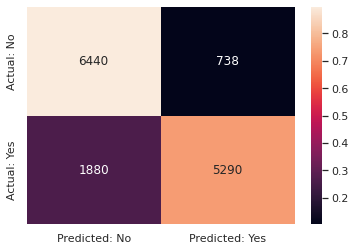

In [74]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, Y_train)
pred_log = log_reg.predict_proba(X_test_scaled)[:, 1]
y_pred = log_reg.predict(X_test_scaled)

print(f"ROC AUC score of Logistic Regression: {roc_auc_score(Y_test, pred_log):.4f}")
print(f"Recall score of Logistic Regression: {recall_score(Y_test, y_pred):.4f}")
confusion_matrix_plot(cm_log)
plt.show()

Comparing both recall and roc auc score we got earlier is far more better than the ones with the important features. Therefore, we will make use of the previous model created earlier.